Ticker selections
=================

In [1]:
# If you would like to refresh your data, please execute the bellow codes.

import pandas as pd
from datetime import datetime
from tqdm import tqdm

from mypo import Loader

DOWNLOAD = False

if DOWNLOAD:
    tickers = pd.read_csv("/app/docs/tutorial/tickers.csv")
    loader = Loader()
    for row in tqdm(tickers.to_dict('record')):
        loader.get(row['Ticker'], expense_ratio=row['ExpenseRatio'] * 0.01)
    loader.save('/app/docs/tutorial/all.bin')

In [2]:
loader = Loader.load('/app/docs/tutorial/all.bin')
loader = loader.since(datetime(2005, 1, 1))

market = loader.get_market()

In [3]:
pd.set_option('display.max_rows', 200)

summary = loader.summary()
summary = summary.sort_index()
summary

,established,names,total_assets,volume,expense_ratio
AGG,2003-09-29,iShares Core U.S. Aggregate Bond ETF,85938724864,6466483,0.0005
BBH,1999-11-23,VanEck Vectors Biotech ETF,495472128,6928,0.0035
DIA,1998-01-20,SPDR Dow Jones Industrial Average ETF Trust,25793642496,4995800,0.0016
DVY,2003-11-07,iShares Select Dividend ETF,15882481664,1065285,0.0039
EEM,2003-04-14,iShares MSCI Emerging Markets ETF,29338421248,65868433,0.0070
EFA,2001-08-27,iShares MSCI EAFE ETF,53298008064,24144216,0.0032
EPP,2001-10-26,iShares MSCI Pacific ex Japan ETF,2290522112,271300,0.0048
EWG,1996-03-18,iShares MSCI Germany ETF,2596413952,3059500,0.0051
EWJ,1996-03-18,iShares MSCI Japan ETF,13236024320,6636166,0.0051
EWM,1996-03-18,iShares MSCI Malaysia ETF,380267392,300166,0.0051


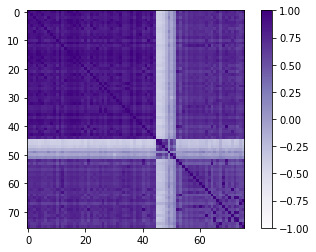

,DIA,VBK,VAW,VUG,VTV,IJR,XLK,XLB,XLI,IOO,...,VDC,XLU,ILF,XLV,XLE,RWR,IXC,OIH,VPU,XLP
DIA,1.000000,0.869771,0.859922,0.929926,0.958851,0.866318,0.888003,0.847780,0.923129,0.938661,...,0.851901,0.687816,0.767659,0.822007,0.767047,0.731212,0.790183,0.673832,0.719169,0.806004
VBK,0.869771,1.000000,0.877067,0.927276,0.888985,0.948652,0.856504,0.845448,0.871164,0.871222,...,0.739583,0.585509,0.750748,0.762026,0.736024,0.742433,0.749881,0.682318,0.626350,0.681020
VAW,0.859922,0.877067,1.000000,0.857148,0.881565,0.863043,0.778800,0.979438,0.875534,0.860293,...,0.713131,0.597504,0.801516,0.691176,0.806604,0.689068,0.821532,0.747929,0.633524,0.657361
VUG,0.929926,0.927276,0.857148,1.000000,0.906242,0.858485,0.947440,0.840877,0.875607,0.931639,...,0.813619,0.642346,0.763365,0.821977,0.726572,0.702638,0.749901,0.649599,0.674983,0.763365
VTV,0.958851,0.888985,0.881565,0.906242,1.000000,0.900183,0.847667,0.859418,0.919426,0.935172,...,0.838729,0.701510,0.779995,0.806847,0.793475,0.794066,0.809794,0.703712,0.735186,0.791998
IJR,0.866318,0.948652,0.863043,0.858485,0.900183,1.000000,0.796108,0.827230,0.881274,0.840896,...,0.741441,0.580604,0.727546,0.717123,0.743758,0.768430,0.749193,0.699281,0.624710,0.685955
XLK,0.888003,0.856504,0.778800,0.947440,0.847667,0.796108,1.000000,0.765053,0.812140,0.885974,...,0.754542,0.585883,0.705930,0.743462,0.646347,0.646965,0.672595,0.573720,0.614441,0.712980
XLB,0.847780,0.845448,0.979438,0.840877,0.859418,0.827230,0.765053,1.000000,0.865323,0.845856,...,0.705967,0.589035,0.782982,0.694629,0.786435,0.662814,0.802208,0.723650,0.621970,0.657360
XLI,0.923129,0.871164,0.875534,0.875607,0.919426,0.881274,0.812140,0.865323,1.000000,0.876364,...,0.769169,0.610453,0.737309,0.749752,0.744118,0.718018,0.765819,0.684192,0.646028,0.726137
IOO,0.938661,0.871222,0.860293,0.931639,0.935172,0.840896,0.885974,0.845856,0.876364,1.000000,...,0.817936,0.662040,0.797623,0.799246,0.768566,0.710299,0.814352,0.679449,0.692349,0.771692


In [4]:
import matplotlib.pyplot as plt
from mypo import clustering_tickers, evaluate_combinations
cluster = clustering_tickers(market, n=4)
corr = market.get_rate_of_change()[cluster.index].corr()

plt.figure()
plt.imshow(corr,interpolation='nearest',vmin=-1,vmax=1,cmap='Purples')
plt.colorbar()
plt.show()

corr

In [5]:
from mypo import split_n_periods
from mypo.optimizer import MinimumVarianceOptimizer, MaximumDiversificationOptimizer
from mypo.indicator import yearly_total_return, max_drawdown, max_drawdown_span
from mypo.rebalancer import MonthlyRebalancer
from mypo import Runner

trains, evals = split_n_periods(market, 5, 200)

  1%|          | 4/783 [00:00<00:20, 38.09it/s]

['IXN', 'SHY', 'GLD', 'OIH']


100%|██████████| 783/783 [00:10<00:00, 77.22it/s]


[0.06813748 0.88622321 0.01744153 0.02819779]
1.0901002722933524
0.9789801847590845
41


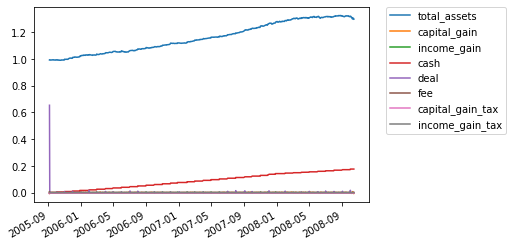

  1%|          | 4/783 [00:00<00:19, 38.98it/s]

['XLF', 'SHY', 'GLD', 'FXI']


100%|██████████| 783/783 [00:10<00:00, 76.32it/s]


[0.028567   0.94087574 0.02408096 0.00647631]
1.0410695650610988
0.9837418243451873
61


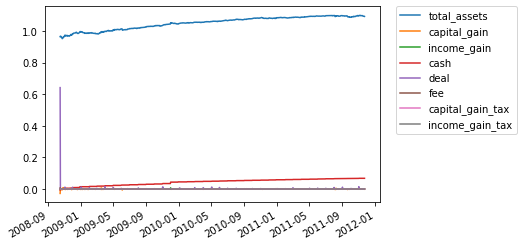

  1%|          | 5/783 [00:00<00:25, 30.84it/s]

['FEZ', 'SHY', 'GLD', 'OIH']


100%|██████████| 783/783 [00:10<00:00, 74.85it/s]


[0.02064511 0.94996691 0.00787756 0.02151042]
1.0063844048229011
0.9888088388896157
133


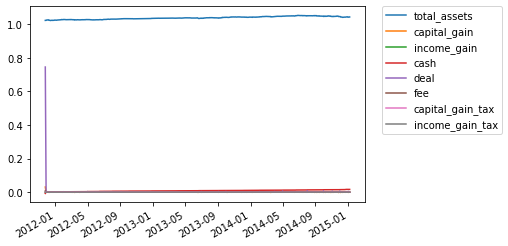

  1%|          | 5/783 [00:00<00:16, 46.16it/s]

['XLF', 'SHY', 'GLD', 'EWZ']


100%|██████████| 783/783 [00:10<00:00, 76.34it/s]


[4.34425874e-02 9.41583889e-01 1.43656788e-18 1.49735234e-02]
1.0175231473826227
0.9891903349365154
169


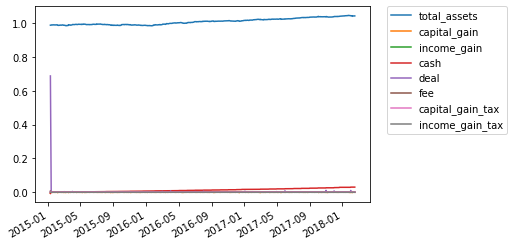

 94%|█████████▍| 12216/12960 [03:44<00:13, 56.62it/s]

In [ ]:
for i in range(len(trains)):
    evaluates = evaluate_combinations(trains[i], cluster, optimizer=MaximumDiversificationOptimizer(), verbose=True)
    print(list(evaluates['combinations'])[0])
    target = evals[i].filter((list(evaluates['combinations'])[0]))
    optimizer = MaximumDiversificationOptimizer()
    runner = Runner(
        assets=[0.25, 0.25, 0.25, 0.25],
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
        cash=0
    )

    runner.run(
        market=target,
        train_span=200,
        verbose=True
    )
    report = runner.report()
    print(optimizer.get_weights())
    print(yearly_total_return(report))
    print(max_drawdown(report))
    print(max_drawdown_span(report))
    ax = report.plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()